# Imports


In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.models as models

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image


import pylab as pl
from IPython import display


import pandas as pd
import numpy as np
import os
from skimage import io
from skimage.transform import rescale
import matplotlib.pyplot as plt

# Custom functions

In [3]:
def convert(image_path, target=224):   
    image = io.imread(image_path)
    rescale_factor = target / image.shape[0],target / image.shape[1]
    scaled = rescale(image, rescale_factor)[:,:,:3]
    scaled = scaled.transpose((-1, 0, 1))
    scaled.shape

    return scaled

def get_countlist(classes,directory):
    countlist = []

    for i, klasse in enumerate(classes):
        output = os.listdir("{}{}".format(directory,klasse))    
        path, dirs, files = next(os.walk("{}{}".format(directory,klasse)))
        file_count = len(files)
        print(f"Class: {i} - {file_count}\t - {classes[i]}")
        countlist.append(file_count)
    
    return countlist

In [4]:
def generate_datasets(directory,class_limit = 10,output_limit = 20,split_ratio = 0.8):
    #class_limit = 10 # max 37
    #output_limit = 20
    #split_ratio = 0.8 # training ratio

    trainlist = []
    trainclass = []
    testlist = []
    testclass = []

    for i, klasse in enumerate(classes[:class_limit+1]):
        output = os.listdir("{}/{}".format(directory,klasse))    
        output_limit = countlist[i] * split_ratio 

        print(f"Class: {i} - {int(output_limit)}/{countlist[i]}\t - {classes[i]}")

        # Loop for training data
        for image_path in output[:int(output_limit+1)]:
            trainlist.append(convert("{}{}/{}".format(directory,klasse, image_path)))
            trainclass.append(klasse)

        # Loop for test data
        for image_path in output[int(output_limit):]:
            testlist.append(convert("{}{}/{}".format(directory,klasse, image_path)))
            testclass.append(klasse)

    trainlist = np.asarray(trainlist)
    testlist = np.asarray(testlist)
    train_oh = pd.get_dummies(pd.DataFrame(trainclass)).values
    test_oh = pd.get_dummies(pd.DataFrame(testclass)).values

    return trainlist, testlist, train_oh, test_oh

# Load dataset

In [16]:
# init functions
directory="./dataset_v2/root/train/classes/"
classes = [x[1] for x in os.walk(directory)][0]

#run helper functions
countlist = get_countlist(classes,directory)
dummy = pd.get_dummies(pd.DataFrame(classes))

# get dataset
x_train, x_test, y_train, y_test = generate_datasets(directory,class_limit = 2,output_limit = 20,split_ratio = 0.8)  

Class: 0 - 362	 - van
Class: 1 - 179	 - truck
Class: 2 - 97	 - green
Class: 3 - 865	 - jeep
Class: 4 - 72	 - ac_vents
Class: 5 - 3080	 - hatchback
Class: 6 - 4	 - harnessed_to_a_cart
Class: 7 - 853	 - sunroof
Class: 8 - 881	 - wrecked
Class: 9 - 414	 - red
Class: 10 - 172	 - enclosed_cab
Class: 11 - 77	 - flatbed
Class: 12 - 53	 - bus
Class: 13 - 5783	 - sedan
Class: 14 - 2	 - ladder
Class: 15 - 586	 - minivan
Class: 16 - 3	 - tanker
Class: 17 - 5	 - dedicated_agricultural_vehicle
Class: 18 - 133	 - enclosed_box
Class: 19 - 742	 - blue
Class: 20 - 164	 - light_truck
Class: 21 - 1158	 - black
Class: 22 - 258	 - yellow
Class: 23 - 44	 - prime_mover
Class: 24 - 383	 - luggage_carrier
Class: 25 - 25	 - minibus
Class: 26 - 256	 - open_cargo_area
Class: 27 - 181	 - spare_wheel
Class: 28 - 17	 - cement_mixer
Class: 29 - 30	 - soft_shell_box
Class: 30 - 626	 - other
Class: 31 - 506	 - large_vehicle
Class: 32 - 3505	 - silver_grey
Class: 33 - 16	 - crane_truck
Class: 34 - 435	 - pickup
Class: 3

/home/bok/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Class: 1 - 143/179	 - truck


# Define neural network
## Prepare pretrained resnet

In [6]:
#define the model
model_conv = models.resnet50(pretrained='imagenet')

# disable autograd for resnet
for param in model_conv.parameters():
    param.requires_grad = False
    
# Change fully connected layer to match paper (autograd is default on new layers)
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_conv = model_conv.to(device)

## Define neural network

In [55]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        # input layer
        self.output = nn.Linear(1024,2)
       

    def forward(self, x):
        x = model_conv(x)
        x = F.relu(x)
        x = self.output(x)
        x = F.softmax(x)
        return x


net = Net()

cuda = torch.cuda.is_available()
if cuda:
    net.cuda()

In [66]:
epoch

29

# Train

In [ ]:
%matplotlib inline
epochs = 30
BATCH_SIZE= 64
valid_every = 2
criterion = nn.MSELoss()  # Your code here!
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9) # Your code here!

# prepare data
inputs_train = torch.tensor(x_train).float()
targets_train = torch.tensor(y_train).float()
inputs_test = torch.tensor(x_test).float()
targets_test = torch.tensor(y_test).float()


device = torch.device("cuda:0" if cuda else "cpu")
print("Using device:", device)

inputs_train.to(device)
targets_train.to(device)
inputs_test.to(device)
targets_test.to(device)

losses_train = pd.DataFrame(columns=['Epoch','Loss'])
losses_valid = pd.DataFrame(columns=['Epoch','Loss'])



for epoch in range(epochs):
    batch_loss = []
   
    net.train()
    for i in range(len(inputs_train[:100]) // BATCH_SIZE):
        batch = inputs_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 
        labels = targets_train[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        output = net(batch)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        print(np.mean(batch_loss))
        
       
    losses_train.loc[epoch] = [epoch+1,np.mean(batch_loss)]
    
    if epoch%valid_every == 0:
        batch_loss = []
        net.eval()
        for i in range(len(inputs_test[:100]) // BATCH_SIZE):
            batch = inputs_test[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 
            labels = targets_test[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] 


            output = net(batch)
            loss = criterion(output, labels)

            batch_loss.append(loss.item())
        
        losses_valid.loc[epoch] = [epoch+1,np.mean(batch_loss)]    
            
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
    pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    display.clear_output(wait=True)   
    


Using device: cpu


/home/bok/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


0.00026715575950220227


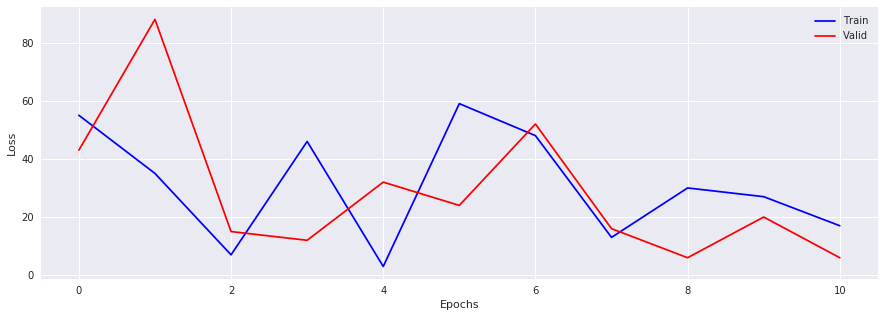

In [172]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
import random


losses_train = pd.DataFrame(columns=['Epoch','Loss'])
losses_valid = pd.DataFrame(columns=['Epoch','Loss'])

#pylab.plot(x, y1, '-b', label='sine')


losses = []
for i in range(11):
    loss_train = random.randint(1,100-i*8)
    loss_valid = random.randint(1,100-i*8)
    losses_train.loc[i] = [i,loss_train]
    losses_valid.loc[i] = [i,loss_valid]
    
    #pl.cla()
    pl.figure(figsize=(15,5))
    pl.xlabel('Epochs')
    pl.ylabel('Loss')
    pl.plot(losses_train['Epoch'],losses_train['Loss'], '-b', label='Train')
    pl.plot(losses_valid['Epoch'],losses_valid['Loss'], '-r', label='Valid')
    pl.legend()
    pl.show()
    display.clear_output(wait=True)
    #display.display(pl.gcf())
    #pl.show()
    time.sleep(1.0)


In [ ]:
num_epoch = 10  # Your code here!

net.train()
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        
        output = net(inputs)
        #pred = torch.max(output,1)[1]
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # forward + backward + optimize
        
        

        # print statistics
        running_loss += loss.data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
# Get training set
inputs, _, targets_in, targets, targets_seqlen, _, _, _, text_targ = generate(TRAINING_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN)
max_target_len = max(targets_seqlen)
inputs = torch.tensor(inputs)
targets = torch.tensor(targets)
targets_in = torch.tensor(targets_in)
unique_text_targets = set(text_targ)

# Get validation set
val_inputs, _, val_targets_in, val_targets, val_targets_seqlen, _, val_text_in, _, val_text_targ = \
    generate(TEST_SIZE, min_len=MIN_SEQ_LEN, max_len=MAX_SEQ_LEN, invalid_set=unique_text_targets)
val_inputs = torch.tensor(val_inputs)
val_targets = torch.tensor(val_targets)
val_targets_in = torch.tensor(val_targets_in)
max_val_target_len = max(val_targets_seqlen)
test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)

# Split training set in batches
inputs = [inputs[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets = [targets[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]
targets_in = [targets_in[i * BATCH_SIZE: (i + 1) * BATCH_SIZE] for i in range(TRAINING_SIZE // BATCH_SIZE)]

# Quick and dirty - just loop over training set without reshuffling
for epoch in range(1, EPOCHS + 1):
    train(encoder, decoder, inputs, targets, targets_in, criterion, enc_optimizer, dec_optimizer, epoch, max_target_len)
    _, loss, accuracy = test(encoder, decoder, val_inputs, val_targets, val_targets_in, criterion, max_val_target_len)
    print('\nTest set: Average loss: {:.4f} \tAccuracy: {:.3f}%\n'.format(loss, accuracy.item()*100.))

    # Show examples
    print("Examples: prediction | input")
    out, _, _ = test(encoder, decoder, val_inputs[:10], val_targets[:10], val_targets_in[:10], criterion, max_val_target_len)
    pred = get_pred(out)
    pred_text = [numbers_to_text(sample) for sample in pred]
    for i in range(10):
        print(pred_text[i], "\t", val_text_in[i])
    print()